In [20]:
import numpy as np
from typing import List, Tuple
from scipy.stats import norm
from tqdm import tqdm
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import display

In [47]:
def compute_f0(fs: List[int]):
    if fs[1] == 0:
        return (fs[0] * (fs[0] - 1)) / (2 * (fs[1]+1))
    return (fs[0]**2) / (2*fs[1])

In [48]:
def compute_variance(fs: List[int], Nhat: float):
    if fs[1] == 0:
        return (
            ((fs[0] * (fs[0] - 1)) / 2) + \
            ((fs[0]*((2.0*fs[0]-1)**2))/4) - \
            ((fs[0]**4)/Nhat)
        )
    # print('B')
    return (
        fs[1] * (
            (1/4)*((fs[0]/fs[1])**4) + \
            (fs[0]/fs[1])**3 + \
            ((1/2) * ((fs[0] / fs[1])**2))
        )
    )

In [49]:
def compute_confidence_inverval(n:int, f0_hat:float, variance:float, alpha:float):
    """
    Computes the 100(1-alpha)% confidence interval for N 
    """
    z_alpha = norm.ppf(1-(alpha/2))
    Q = np.exp(z_alpha * np.sqrt(np.log(1+((variance)/(f0_hat**2)))))
    return (
        n + (f0_hat / Q),
        n + (f0_hat * Q)
    )

In [50]:
def compute_fs(num_caught: np.ndarray, T: int):
    fs = np.zeros(T-1)
    for t in range(1, T):
        fs[t-1] = np.sum(num_caught == t)
    return fs.tolist()

### Single Run

In [51]:
N = 1000
T = 40
alpha = 0.01
np.random.seed(0)


num_caught = np.zeros(N)

history_N_hat = []
history_variance = []
history_f0_hat = []
history_true_f0 = []
history_confidence_interval = []

for t in tqdm(range(T), desc="Simulating..."):
    # uniform U(0.0, 0.01)
    probability_caught = np.random.uniform(0, 0.01, N)
    # # uniform U(0.0, 0.02)
    # probability_caught = np.random.uniform(0, 0.02, N)
    # # beta distribution B(1, 3)
    # probability_caught = 0.02 * np.random.beta(1, 3, N)
    # # beta distribution B(2, 2)
    # probability_caught = 0.02 * np.random.beta(2, 2, N)


    is_caught = np.random.uniform(0, 1, N) < probability_caught
    num_caught += is_caught

    fs = compute_fs(num_caught, T)
    n = sum(fs)
    f0_hat = compute_f0(fs)
    N_hat = n + f0_hat
    variance = compute_variance(fs, N_hat)
    confidence_interval = compute_confidence_inverval(n, f0_hat, variance, alpha)

    history_N_hat.append(N_hat)
    history_variance.append(variance)
    history_f0_hat.append(f0_hat)
    history_true_f0.append((num_caught == 0).sum())
    history_confidence_interval.append(confidence_interval)

Simulating...: 100%|██████████| 40/40 [00:00<00:00, 7611.48it/s]


In [44]:
print(np.array(history_variance))
print(np.array(history_confidence_interval))

[  231.          1795.39285714 10882.83333333 33270.30882353]
[[  10.94632388  118.74957071]
 [  34.04911518  302.03827781]
 [ 114.1670999   725.10635274]
 [ 255.34183454 1286.85310673]]


In [45]:
print(np.array(history_N_hat))

[ 28.  91. 276. 561.]


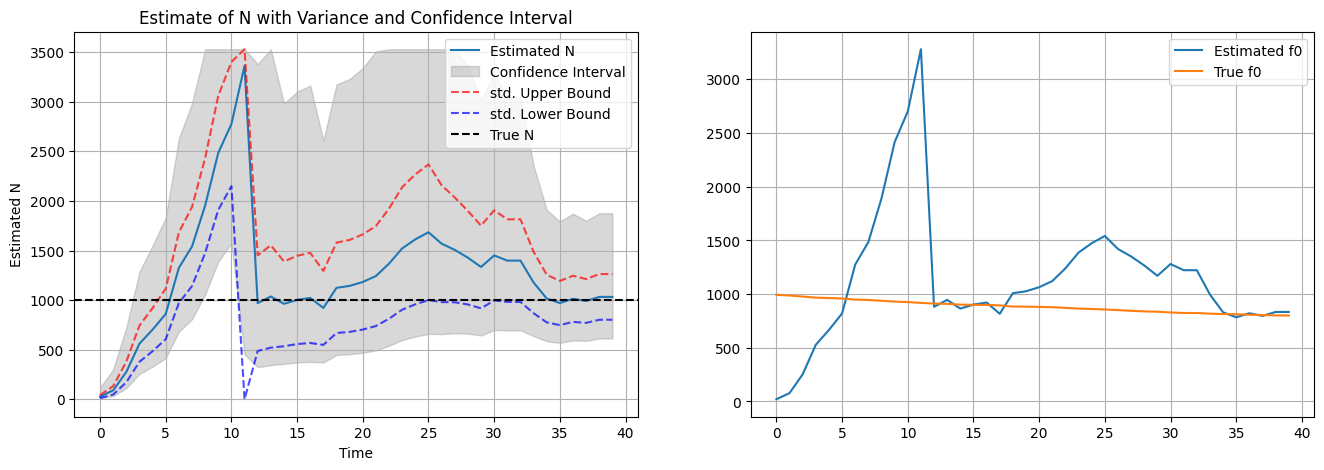

In [55]:
fig, ax = plt.subplots(1, 2,figsize=(16, 5))

# ax[0].plot(history_N_hat)
ax[0].set_title("Estimate of N with Variance and Confidence Interval")
ax[0].set_xlabel("Time")
ax[0].set_ylabel("Estimated N")
ax[0].plot(history_N_hat, label="Estimated N")

# Plot the variance upper bound but clip values above the original y-axis limits so the scale is unaffected
ymin, ymax = ax[0].get_ylim()

# Plot the confidence interval but clip values outside the original y-axis limits so the scale is unaffected
ci_lower = [max(ci[0], ymin) for ci in history_confidence_interval]
ci_upper = [min(ci[1], ymax) for ci in history_confidence_interval]
ax[0].fill_between(
    range(len(history_N_hat)),
    ci_lower,
    ci_upper,
    color="grey", alpha=0.3, label="Confidence Interval"
)

upper_var = [n + v for n, v in zip(history_N_hat, np.sqrt(np.array(history_variance)))]
# Keep unchanged values within limits, but clip values above ymax to ymax (so they are drawn but do not affect scale)
upper_var_clipped = [val if val <= ymax else ymax for val in upper_var]
ax[0].plot(
    upper_var_clipped,
    'r--', alpha=0.7, label="std. Upper Bound"
)
ax[0].plot(
    [n - v if n - v > 0 else 0 for n, v in zip(history_N_hat, np.sqrt(np.array(history_variance)))],
    'b--', alpha=0.7, label="std. Lower Bound"
)
ax[0].axhline(y=N, color='r', linestyle='--', c='black', label="True N")
ax[0].legend()

ax[1].plot(history_f0_hat, label="Estimated f0")
ax[1].plot(history_true_f0, label="True f0")
ax[1].legend()

ax[0].grid(True)
ax[1].grid(True)

plt.show()

In [56]:
(num_caught == 0).sum()

np.int64(801)

### Multiple Runs

In [57]:
def simulate(N: int, alpha: float, seed: int, progress: bool = False):
    np.random.seed(seed)
    T = 40
    # N = 1000
    # alpha = 0.01

    num_caught = np.zeros(N)

    # history_N_hat = []
    # history_variance = []
    # history_f0_hat = []
    # history_true_f0 = []
    # history_confidence_interval = []

    for t in tqdm(range(T), desc="Simulating...", disable=not progress):
        # uniform U(0.0, 0.01)
        probability_caught = np.random.uniform(0, 0.01, N)
        # # uniform U(0.0, 0.02)
        # probability_caught = np.random.uniform(0, 0.02, N)
        # # beta distribution B(1, 3)
        # probability_caught = 0.02 * np.random.beta(1, 3, N)
        # # beta distribution B(2, 2)
        # probability_caught = 0.02 * np.random.beta(2, 2, N)


        is_caught = np.random.uniform(0, 1, N) < probability_caught
        num_caught += is_caught

    fs = compute_fs(num_caught, T)
    n = sum(fs)
    f0_hat = compute_f0(fs)
    N_hat = n + f0_hat
    variance = compute_variance(fs, N_hat)
    confidence_interval = compute_confidence_inverval(n, f0_hat, variance, alpha)

    return N_hat, f0_hat, variance, confidence_interval

    # history_N_hat.append(N_hat)
    # history_variance.append(variance)
    # history_f0_hat.append(f0_hat)
    # history_true_f0.append((num_caught == 0).sum())
    # history_confidence_interval.append(confidence_interval)

In [75]:
def evaluate_data(
    _N_hats: List[float], 
    _f0_hats: List[float], 
    _variances: List[float], 
    _confidence_intervals: List[Tuple[float, float]],
    export: str = 'table'
    ):
    N_hat_means = np.mean(_N_hats)
    N_hat_stds = np.std(_N_hats)
    f0_hat_means = np.mean(_f0_hats)
    f0_hat_stds = np.std(_f0_hats)
    variance_means = np.mean(_variances)
    variance_stds = np.std(_variances)
    confidence_lower = np.array(_confidence_intervals)[:, 0]
    confidence_upper = np.array(_confidence_intervals)[:, 1]
    confidence_interval_lower_means = np.mean(confidence_lower)
    confidence_interval_lower_stds = np.std(confidence_lower)
    confidence_interval_upper_means = np.mean(confidence_upper)
    confidence_interval_upper_stds = np.std(confidence_upper)

    data = {
        "Metric": [
            "N_hat",
            # "f0_hat",
            "Variance",
            "Std",
            "Confidence Interval Lower",
            "Confidence Interval Upper"
        ],
        "Mean": [
            f"{N_hat_means:.2f}",
            # f"{f0_hat_means:.2f}",
            f"{variance_means:.2f}",
            f"{np.mean(np.sqrt(_variances)):.2f}",
            f"{confidence_interval_lower_means:.2f}",
            f"{confidence_interval_upper_means:.2f}",
        ],
        "Std": [
            f"{N_hat_stds:.2f}",
            # f"{f0_hat_stds:.2f}",
            f"{variance_stds:.2f}",
            f"{np.std(np.sqrt(_variances)):.2f}",
            f"{confidence_interval_lower_stds:.2f}",
            f"{confidence_interval_upper_stds:.2f}"
        ]
    }
    table = pd.DataFrame(data)

    if export == 'table':
        display(table)
    elif export == 'latex':
        print(table.to_latex(index=False))
    else:
        raise ValueError(f"Invalid export format: {export}")


In [88]:
num_runs = 1_000
N = 5000
alpha = 0.01
N_hats, f0_hats, variances, confidence_intervals = [], [], [], []

for run in tqdm(range(num_runs), desc="Running Simulations...", unit="runs"):
    N_hat, f0_hat, variance, confidence_interval = simulate(N=N, alpha=alpha, seed=run, progress=False)

    N_hats.append(N_hat)
    f0_hats.append(f0_hat)
    variances.append(variance)
    confidence_intervals.append(confidence_interval)

evaluate_data(
    _N_hats=N_hats,
    _f0_hats=f0_hats,
    _variances=variances,
    _confidence_intervals=confidence_intervals,
    # export='latex'
    export='table'
)

Running Simulations...: 100%|██████████| 1000/1000 [00:01<00:00, 761.76runs/s]


,Metric,Mean,Std
0,N_hat,5152.14,583.41
1,Variance,330364.77,120187.90
2,Std,566.36,98.00
3,Confidence Interval Lower,3922.46,383.08
4,Confidence Interval Upper,6884.52,890.63


In [90]:
(5152.14-5000)/5000

0.030428000000000066

In [92]:
(1096.62 - 1000)/1000

0.09661999999999989

In [91]:
(590.45 - 500)/500

0.1809000000000001